In [1]:
# file-handling
import os 

# user status updates
import time
from tqdm import tqdm
from IPython.display import display, Latex

# the holy trinity of python
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# scipy
import scipy
from scipy import sparse, linalg, fft
from scipy.linalg import expm, sinm, cosm
import scipy.integrate as integrate
from scipy.integrate import quad

# parallelization, memory management
from joblib import Parallel, delayed
from numba import jit, njit, prange
import copy

# itertools
import itertools

############ Macros ###############
np.random.seed(0)

# Physical constants
K = 6 # number of fermionic modes
J = 4 # ~"energy scale"
Q_COUPLING = 3 # order of coupling, don't want to use the letter 'Q' because that denotes the supercharge
N = 2*K # number of fermions
N_DIM = 2**N # Hilbert space dimension <-- Important: Hilbert space dimension is now 2^N instead of 2^(N/2). 

N_SAMPLES = 100 # number of samples to generate
N_JOBS = 20 # number of jobs to run in parallel

# Whether we want to check algebra
CHECK_ALGEBRA = False


# 1. Fermion operators

Since we can't use memoization simultaneously with parallelization, we will instead precomputed all our desired values, and use those precomputed values in the parallelization

### 1.a. Define and precompute first N fermions

In [2]:
cr = sparse.csr_array(np.array([[0,1],[0,0]]))
an = sparse.csr_array(np.array([[0,0],[1,0]]))
id = sparse.csr_array(np.identity(2))
id2 = sparse.csr_array(np.array([[-1,0],[0,1]]))

def psi(n):
    factors = [id for i in range(n-1)]+[cr]+[id2 for i in range(N-n)]
    out = factors[0]
    for i in range(1, N):
        out = sparse.kron(out,factors[i])
    return out
psi_all = Parallel(n_jobs=N_JOBS)(delayed(psi)(n) for n in range(1,N+1))
psi_all = {k+1:v for k,v in enumerate(psi_all)}

def psi_dagger(n):
    factors = [id for i in range(n-1)]+[an]+[id2 for i in range(N-n)]
    out = factors[0]
    for i in range(1, N):
        out = sparse.kron(out,factors[i])
    return out
psi_dagger_all = Parallel(n_jobs=N_JOBS)(delayed(psi_dagger)(n) for n in range(1,N+1))
psi_dagger_all = {k+1:v for k,v in enumerate(psi_dagger_all)}

# Confirm that psi_dagger as defined indeed gives psi_dagger
for i, psi_i in psi_all.items():
    psi_daggeri = psi_dagger_all[i]
    assert(np.allclose(np.transpose(np.conjugate(psi_i.toarray())), psi_daggeri.toarray()))

### 1.b. Precompute pairwise dot-products of psi's and psi_dagger's

In order to check that the algebra is satisfied, we would need every pairwise combination of $\psi_i, \psi_j$, $\psi_i, \psi_j^\dagger$, $\psi_i^\dagger, \psi_j^\dagger$.

Otherwise, only need $\psi^i, \psi^j$ where $i<N$, $j>i$

In [3]:
def psi_psi(i, j):
    return psi_all[i]@psi_all[j]

def psi_psi_dagger(i, j):
    return psi_all[i]@psi_dagger_all[j]

def psi_dagger_psi(i, j):
    return psi_dagger_all[i]@psi_all[j]

def psi_dagger_psi_dagger(i, j):
    return psi_dagger_all[i]@psi_dagger_all[j]

############################################################################################
tic = time.time()

# If we're not checking the algebra, only necessary to compute psi_pairs at i<N, j>i
if CHECK_ALGEBRA:
    i_iter = range(N)
else:
    i_iter = range(N-1)

psi_pairs = {}
for i in i_iter:
    if CHECK_ALGEBRA:   
        j_iter = range(N)
    else:
        j_iter = range(i+1, N)

    psi_psi_i = Parallel(n_jobs=N_JOBS)(delayed(psi_psi)(i+1, j+1) for j in j_iter)
    psi_psi_i = {(i+1, i+j+2):v for j,v in enumerate(psi_psi_i)}
    psi_pairs.update(psi_psi_i)
print("psi_pairs done")


if CHECK_ALGEBRA:
    psi_psi_dagger_pairs = {}
    for i in range(N):
        psi_psi_dagger_i = Parallel(n_jobs=N_JOBS)(delayed(psi_psi_dagger)(i+1, j+1) for j in range(N))
        psi_psi_dagger_i = {(i+1, i+j+2):v for j,v in enumerate(psi_psi_dagger_i)}
        psi_psi_dagger_pairs.update(psi_psi_dagger_i)
    print("psi_psi_dagger_pairs done")

    psi_dagger_psi_pairs = {}
    for i in range(N):
        psi_dagger_psi_i = Parallel(n_jobs=N_JOBS)(delayed(psi_dagger_psi)(i+1, j+1) for j in range(N))
        psi_dagger_psi_i = {(i+1, i+j+2):v for j,v in enumerate(psi_dagger_psi_i)}
        psi_dagger_psi_pairs.update(psi_dagger_psi_i)
    print("psi_dagger_psi_pairs done")

    psi_dagger_psi_dagger_pairs = {}
    for i in range(N):
        psi_dagger_psi_dagger_i = Parallel(n_jobs=N_JOBS)(delayed(psi_dagger_psi_dagger)(i+1, j+1) for j in range(N))
        psi_dagger_psi_dagger_i = {(i+1, i+j+2):v for j,v in enumerate(psi_dagger_psi_dagger_i)}
        psi_dagger_psi_dagger_pairs.update(psi_dagger_psi_dagger_i)
    print("psi_dagger_psi_dagger_pairs done")


toc = time.time()
duration = toc - tic
print(f"\nDuration: {duration//60} minutes, {duration%60} seconds")


psi_pairs done

Duration: 1.0 minutes, 6.325455665588379 seconds


### 1.c. Check that they satisfy the given algebra

In this case, our fermions are actually the "fermionic mode" operators from the original SYK model. In other words, they satisfy the anticommutation relations:

$\{ \psi^i, \bar{\psi_j} \} = \delta^i_j$

$\{ \psi^i, \psi^j \} = 0$

$\{ \bar{\psi_i}, \bar{\psi_j} \} = 0$

In [4]:
def process_j(i_index, j_index):
    psi_algebra_satisfied_ij = True

    i_label = i_index+1
    j_label = j_index+1

    # ac_i_j = psi(i)@psi(j)+psi(j)@psi(i)
    ac_i_j = psi_pairs[(i_label,j_label)]+psi_pairs[(j_label,i_label)]
    ac_i_j = ac_i_j.toarray()
    if not np.allclose(ac_i_j, np.zeros((N_DIM, N_DIM))):
        psi_algebra_satisfied_ij = False

    # ac_id_jd = psi_dagger(i)@psi_dagger(j)+psi_dagger(j)@psi_dagger(i)
    ac_idagger_jdagger = psi_dagger_psi_dagger_pairs[(i_label, j_label)]+psi_dagger_psi_dagger_pairs[(j_label, i_label)]
    ac_idagger_jdagger = ac_idagger_jdagger.toarray()
    if not np.allclose(ac_idagger_jdagger, np.zeros((N_DIM, N_DIM))):
        psi_algebra_satisfied_ij = False

    ac_i_jdagger = psi_psi_dagger_pairs[(i_label, j_label)]+psi_dagger_psi_pairs[(j_label, i_label)]
    ac_i_jdagger = ac_i_jdagger.toarray()
    if i_label==j_label:
        if not np.allclose(ac_i_jdagger, np.identity(N_DIM)):
            psi_algebra_satisfied_ij = False
    else:
        if not np.allclose(ac_i_jdagger, np.zeros((N_DIM, N_DIM))):
            psi_algebra_satisfied_ij = False

    return psi_algebra_satisfied_ij

if CHECK_ALGEBRA:
    print("Checking fermion algebra...")
    psi_algebra_satisfied = True
    tic = time.time()
    for i_index in tqdm(range(N)):

        # anticommutator(A, B) \equiv anticommutator(A, B), for ANY operators A, B
        # Since these are all anticommutation relations, it's therefore only necessary to check for j>=i 
        # Note that we do have to include j==i because that's in the prescribed anticommutation relations
        psi_algebra_satisfied_i = Parallel(n_jobs=N_JOBS)(delayed(process_j)(i_index, j_index) for j_index in range(i, N))
        if False in psi_algebra_satisfied_i:
            psi_algebra_satisfied = False
            break

        if i_index==0:
            duration = time.time() - tic
            n_jobs = N
            exp_dur = duration*n_jobs
            print(f"Expected duration: {exp_dur//60} minutes, {exp_dur%60} seconds")

    toc = time.time()
    duration = toc - tic
    print(f"\nDuration: {duration//60} minutes, {duration%60} seconds")
    print(f"Fermion algebra satisfied: {psi_algebra_satisfied}")

### 1.e. Precompute triple inner-products psi-psi-psi

Since there are no comprehensive anticommutation relations to check for triple inner-products, we only need $i<j<k$, in the definition of the Hamiltonian

In [5]:
def psi_psi_psi(i,j,k):
    psi_ij = psi_pairs[(i, j)]
    psi_ijk = psi_ij@psi_all[k]
    return psi_ijk

tic = time.time()

psi_psi_psi_tris = {}
for i in tqdm(range(N-2)):
    psi_psi_psi_i = {}

    for j in range(i+1, N-1):
        psi_psi_psi_ij = Parallel(n_jobs=N_JOBS)(delayed(psi_psi_psi)(i+1, j+1, k+1) for k in range(j+1, N))
        psi_psi_psi_ij = {(i+1, j+1, j+k+2):v for k,v in enumerate(psi_psi_psi_ij)}
        psi_psi_psi_i.update(psi_psi_psi_ij)

    if i==0:
        duration = time.time() - tic
        n_jobs = N-2
        exp_dur = duration*n_jobs
        print(f"Expected duration: {exp_dur//60} minutes, {exp_dur%60} seconds\n")
    
    psi_psi_psi_tris.update(psi_psi_psi_i)

duration = time.time() - tic
print(f"Duration: {duration//60} minutes, {duration%60} seconds")

 10%|█         | 1/10 [01:03<09:30, 63.43s/it]

Expected duration: 10.0 minutes, 34.25121784210205 seconds



100%|██████████| 10/10 [10:28<00:00, 62.82s/it]

Duration: 10.0 minutes, 28.210167169570923 seconds


# 2. Random coefficients

We generate complex gaussian $C \sim \mathcal{N}(0, \sigma_C)$ by defining $C = X + iY$,  

where $X \sim \mathcal{N}(0, \sigma_X)$, $Y \sim \mathcal{N}(0, \sigma_Y)$

and $\sigma_X=\sigma_Y=\frac{\sigma_C}{\sqrt{2}}$.

In [6]:
sigma_C = np.sqrt(2*J/(N**2))
sigma_XY = sigma_C/np.sqrt(2)
X = np.random.normal(0, sigma_XY, size=(N, N, N))
Y = np.random.normal(0, sigma_XY, size=(N, N, N))
C = X + 1j*Y

Confirm that this is in line with equation 5.4: 

$\overline{C_{ijk} \bar{C}^{ijk}} = \frac{2J}{N^2}$

In [7]:
declared_variance = sigma_C**2
C_bar = np.conjugate(C)
computed_variance = np.mean(np.mean(np.mean(C*C_bar)))

print(f"Declared variance: {declared_variance}, Computed variance: {computed_variance}")
print(f"Abs diff: {np.abs(computed_variance-declared_variance)}")
print(f"Percent abs diff: {100*np.abs(computed_variance-declared_variance)/declared_variance:.2f}%")

Declared variance: 0.05555555555555555, Computed variance: (0.053162164762167174+0j)
Abs diff: 0.002393390793388378
Percent abs diff: 4.31%


## 3. Supercharge, $Q$

Compute it

In [8]:
Q = sparse.csr_array(np.zeros((N_DIM, N_DIM), dtype=np.complex128))
tic = time.time()
for i_index in range(N-2):
    i_label = i_index+1

    for j_index in range(i_index+1, N-1):
        j_label = j_index+1

        for k_index in range(j_index+1, N):
            k_label = k_index+1

            C_ijk = C[i_index, j_index, k_index]
            psi_ijk = psi_psi_psi_tris[(i_label, j_label, k_label)]
            Q += C_ijk*psi_ijk
        
    if (i_index==0):
        duration = time.time() - tic
        n_jobs = N-Q_COUPLING
        exp_dur = duration*n_jobs

Q *= 1j
Q_bar = np.transpose(np.conjugate(Q))

Check if Hermitian

In [9]:
print(f"Q hermitian: {linalg.ishermitian(Q.toarray())}")
print(f"Q_bar hermitian: {linalg.ishermitian(Q_bar.toarray())}")

Q hermitian: False
Q_bar hermitian: False


Confirm $Q^2=\bar{Q}^2=0$

In [10]:
Q2 = (Q@Q).toarray()
display(Latex(f"$Q^2=0$: {np.allclose(Q2, np.zeros(Q2.shape))}"))

Q_bar_2 = (Q_bar@Q_bar).toarray()
display(Latex(f"$Qbar^2=0$: {np.allclose(Q2, np.zeros(Q2.shape))}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Confirm equation (5.2.a):

$\{ Q, \psi^i \}=0$

In [11]:
def anticommutator(a,b):
    return a@b+b@a

for i_index in range(N):
    i_label = i_index+1
    
    ac_Q_i = anticommutator(Q, psi(i_label)).toarray()
    print(np.allclose(ac_Q_i, np.zeros(ac_Q_i.shape)))

    abs_diff = np.sum(np.sum(np.abs(ac_Q_i)))
    print(f"abs_diff: {abs_diff}\n")

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0



Confirm equation (5.2.b):

$\{Q, \bar{\psi_i}\} = \bar{b^i} = i \sum_{1\le j<k\le N} C_{ijk} \psi^j \psi^k$

In [12]:
for i_index in range(N):
    i_label = i_index+1
    ac_Q_idagger = anticommutator(Q, psi_dagger_all[(i_label)]).toarray()

    rhs = np.zeros(Q.shape)
    for j_index in range(N-1):
        j_label = j_index+1
        for k_index in range(j_index+1, N):
            k_label = k_index+1

            C_ijk = C[i_index, j_index, k_index]
            psi_jk = psi_pairs[(j_label, k_label)]
            rhs += C_ijk*psi_jk

    rhs *= 1j
    print(np.allclose(ac_Q_idagger, rhs))

    abs_diff = np.sum(np.sum(np.abs(ac_Q_idagger, rhs)))
    print(f"abs_diff: {abs_diff}\n")

False
abs_diff: (29282.941969638538+0j)

False
abs_diff: (29292.815137195314+0j)

False
abs_diff: (29124.1666650015+0j)

False
abs_diff: (29703.948896611862+0j)

False
abs_diff: (29455.07202132972+0j)

False
abs_diff: (28960.109302408382+0j)

False
abs_diff: (29358.04569142036+0j)

False
abs_diff: (29716.493838519185+0j)

False
abs_diff: (29670.560237889185+0j)

False
abs_diff: (28610.524493219917+0j)



KeyboardInterrupt: 

## 4. Hamiltonian

In [27]:
def anticommutator(A,B):
    return A@B+B@A

Q_bar = np.transpose(np.conjugate(Q))
H = anticommutator(Q, Q_bar)

print(f"H hermitian: {linalg.ishermitian(H.toarray())}")

H hermitian: True


(array([1260.,  252.,  260.,  236.,  252.,  260.,  260.,  228.,  208.,
         192.,  156.,  124.,  116.,   84.,   72.,   56.,   36.,   32.,
           8.,    4.]),
 array([-1.58931354e-14,  5.99401359e-01,  1.19880272e+00,  1.79820408e+00,
         2.39760543e+00,  2.99700679e+00,  3.59640815e+00,  4.19580951e+00,
         4.79521087e+00,  5.39461223e+00,  5.99401359e+00,  6.59341495e+00,
         7.19281630e+00,  7.79221766e+00,  8.39161902e+00,  8.99102038e+00,
         9.59042174e+00,  1.01898231e+01,  1.07892245e+01,  1.13886258e+01,
         1.19880272e+01]),
 <BarContainer object of 20 artists>)

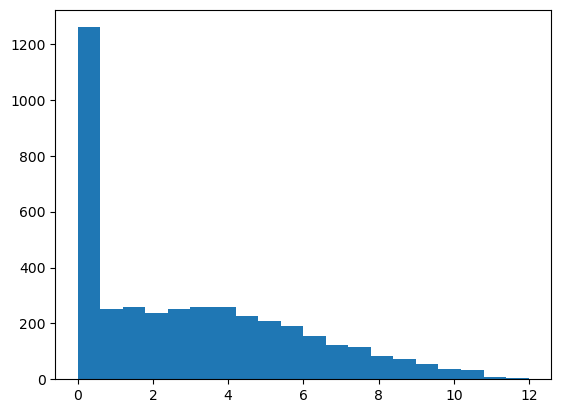

In [28]:
iv = np.linalg.eigvalsh(H.toarray())
iv = np.sort(iv)
plt.hist(iv, bins=20)

Important question: How small is small-enough to consider it "exactly 0"?